# Ball and players detection for SoccerNet
### Using pretrained VGG-16 (Very-Deep CNN)

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import torch.optim as optim
import torch
from torch import nn
from torch.nn import LocalResponseNorm
import cv2
import math

import pandas as pd
from sklearn import metrics

from skimage.io import imread
from skimage.transform import resize

In [65]:
import os.path
import pathlib

# Data split
directory_train = '/tmp/train/proj_test'

# Load Train data
train_labels = pd.read_csv(directory_train + "/proj_det/det.txt", sep=',', index_col=0)
train_images = directory_train + "/proj_img1/{}.jpg"
train_images = [train_images.format(str(i).zfill(6)) for i in train_labels.frame.values]
train_labels = [train_labels.columns.values.tolist()] + train_labels.values.tolist() # Convert DF to list

#print(train_labels[0:5][0:7])

# Load Test data
directory_test = 'tmp/test/proj_test/'

test_labels = pd.read_csv(directory_test + '/proj0_det/det.txt', sep=',', index_col=0)
test_images = directory_test + "/proj_img1/{}.jpg"
test_images = [test_images.format(str(i).zfill(6)) for i in test_labels.frame.values]
test_labels = [test_labels.columns.values.tolist()] + test_labels.values.tolist() # Convert DF to list

In [66]:
# Create image dataset class
class img_dataset():
    def __init__(self, height, width, dir_img, labels_list, images, mode='train') -> None:
        self.height = height
        self.width = width
        self.dir_img = dir_img
        self.labels_list = labels_list
        self.images=images

    def __getitem__(self,id):
        boxes = []
        labels = []
        img_name = self.images[id]
        print(img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(img_name)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        for line in self.labels_list:
            parsed = [float(x) for x in line.split(',')]
            if int(self.labels_list[line][0]) == int(self.images[id][-10:-4]):
                x = self.labels_list[line][2]
                y = self.labels_list[line][3]
                width = self.labels_list[line][4]
                height = self.labels_list[line][5]
                boxes.append([x,y,width,height])
                labels.append(self.labels_list[line][7])
            else: break
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        image_id = torch.tensor([id])
        target["image_id"] = image_id
        return self.images[id],boxes

In [67]:
train_ds = img_dataset(1920,1080,directory_train + "/proj_img1/",train_labels,train_images)
test_ds = img_dataset(1920,1080,directory_test + "/proj_img1/",test_labels,test_images, mode='test')

[tensor([[[ 38,  40,  42,  ..., 107, 107, 107],
         [ 37,  39,  41,  ..., 101, 102, 103],
         [ 35,  37,  40,  ...,  66,  66,  67],
         ...,
         [110, 111, 111,  ..., 111, 111, 111],
         [110, 111, 111,  ..., 112, 113, 114],
         [110, 111, 111,  ..., 113, 115, 116]],

        [[ 39,  41,  43,  ..., 108, 108, 108],
         [ 38,  40,  42,  ..., 102, 103, 104],
         [ 36,  38,  41,  ...,  67,  67,  68],
         ...,
         [135, 137, 137,  ..., 140, 140, 140],
         [135, 137, 137,  ..., 141, 142, 143],
         [135, 137, 137,  ..., 142, 144, 145]],

        [[ 41,  43,  45,  ..., 100, 100, 100],
         [ 40,  42,  44,  ...,  94,  95,  96],
         [ 38,  40,  43,  ...,  59,  59,  60],
         ...,
         [ 67,  66,  66,  ...,  56,  56,  56],
         [ 67,  66,  66,  ...,  57,  58,  59],
         [ 67,  66,  66,  ...,  58,  60,  61]]], dtype=torch.uint8)]


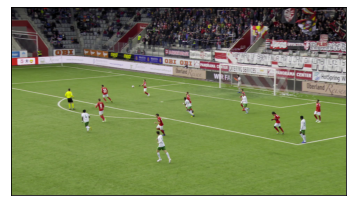

In [68]:
# Data visualization
from torchvision.io import read_image
from torchvision.utils import make_grid
import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

img_list = []
for i in range(0,1):
    img = read_image(train_images[i])
    img_list.append(img)

print(img_list)
grid = make_grid(img_list)
show(grid)

In [5]:
# Import pre-trained model and load in GPU if possible.
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reference (technical paper): https://arxiv.org/pdf/1409.1556.pdf
# Create a list with 3 different pre-trained models to compare: VGG16, Resnet50, GoogLeNet
model_trained = models.vgg16(pretrained=True)

In [6]:
# Definition of the loss criterion and the optimizer.
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_trained.parameters(), lr=0.008)

out_features = 2
print(model_trained)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
# Definition of output size and last FFNN layer.
## COMMENT: VGG-16 is meant to handle up 1000 output classes. 
## we will redefine the output class number.

last_layer_infeatures = model_trained.classifier[6].in_features
model_trained.fc = nn.Linear(last_layer_infeatures, out_features)
model_trained.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1